In [1]:
# Import libraries needed in this research
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from pylab import figure, axes, pie, title, savefig

from scipy.linalg import lstsq

In [2]:
np.random.seed(0)

In [3]:
# def Cite_Over_Gap(cite, PatDate, gaps):
#     temp = pd.merge(cite, PatDate, how="left", on="wku")
#     temp = pd.merge(temp, PatDate, how="left", left_on="citing", right_on="wku")
#     outputs = temp[(temp.filed_year_y-temp.filed_year_x<=gaps)& \
#                    (temp.filed_year_y-temp.filed_year_x>=0)][["wku_x","citing","filed_year_x"]]
#     outputs.columns = ["wku","citing","filed_year"]
#     outputs=outputs.groupby(["wku","filed_year"], as_index=False).count()
#     return outputs

In [4]:
# cross validations to find the ideal parameter for C and epsilon
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    epsilons = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'epsilon' : epsilons}
    grid_search = GridSearchCV(LinearSVR(fit_intercept=False), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [5]:
# Read NBER(2006) patent data and updated_patent_data generated from Patent prediction code
CitationInfo = pd.read_stata("nber data/3930271_7155745_citation.dta")
YearInfo     = pd.read_stata("nber data/3930271_7155745_date.dta")
###Read Prof.Amit's file to keep the result constant.
###This could be replace with Linear SVR output from patent prediction code.
# PatInfo = pd.read_csv("updated_patent_data.csv") 
PatInfo = pd.read_csv("updated_patent_data_Amit.csv") 


In [6]:
# Create 8 lag variable for file year/class/patent id/firm id
PatInfo = PatInfo.sort_values(["gvkey","cat_code","filed_year"])
for i in range(1,8):
    PatInfo["filed_year_"+str(i)] = PatInfo["filed_year"].shift(i)
    PatInfo["cat_code_"+str(i)] = PatInfo["cat_code"].shift(i)
    PatInfo["wku_"+str(i)] = PatInfo["wku"].shift(i)
    PatInfo["gvkey_"+str(i)] = PatInfo["gvkey"].shift(i)
#print PatInfo.head(10)

In [7]:
# The and operation applied here is tring to make sure each record/row have no Nah values,
# which means to make sure the input feature matrix for the later prediction has no Nahs.
PatInfo = PatInfo[(PatInfo.gvkey==PatInfo.gvkey_1)& \
                                                  (PatInfo.gvkey==PatInfo.gvkey_2)& \
                                                  (PatInfo.gvkey==PatInfo.gvkey_3)& \
                                                  (PatInfo.gvkey==PatInfo.gvkey_4)& \
                                                  (PatInfo.gvkey==PatInfo.gvkey_5)& \
                                                  (PatInfo.gvkey==PatInfo.gvkey_6)& \
                                                  (PatInfo.gvkey==PatInfo.gvkey_7)& \
                                                  (PatInfo.cat_code==PatInfo.cat_code_1)& \
                                                  (PatInfo.cat_code==PatInfo.cat_code_2)& \
                                                  (PatInfo.cat_code==PatInfo.cat_code_3)& \
                                                  (PatInfo.cat_code==PatInfo.cat_code_4)& \
                                                  (PatInfo.cat_code==PatInfo.cat_code_5)& \
                                                  (PatInfo.cat_code==PatInfo.cat_code_6)& \
                                                  (PatInfo.cat_code==PatInfo.cat_code_7)& \
                                                  (PatInfo.filed_year==PatInfo.filed_year_1+1)& \
                                                  (PatInfo.filed_year==PatInfo.filed_year_2+2)& \
                                                  (PatInfo.filed_year==PatInfo.filed_year_3+3)& \
                                                  (PatInfo.filed_year==PatInfo.filed_year_4+4)& \
                                                  (PatInfo.filed_year==PatInfo.filed_year_5+5)& \
                                                  (PatInfo.filed_year==PatInfo.filed_year_6+6)& \
                                                  (PatInfo.filed_year==PatInfo.filed_year_7+7)]

In [8]:
#print PatInfo.head(10)

In [9]:
# we only use the former six year's wku information. Here we select them.
PatInfo_final = PatInfo[["gvkey","filed_year","cat_code","wku","wku_1","wku_2","wku_3","wku_4","wku_5","wku_6"]]

In [10]:
#print PatInfo_final.head(10)

In [11]:
# Here we get PatInfo_final_cites(A)
PatInfo_final_cites = PatInfo_final
#print PatInfo_final_cites.shape

In [12]:
# Here initialize the merge of the citationInfo and YearInfo to get CitationInfo_date_agg (B)
CitationInfo_date = pd.merge(CitationInfo, YearInfo[["wku","filed_year"]], how="left", on="wku") 
CitationInfo_date = pd.merge(CitationInfo_date , YearInfo[["wku","filed_year"]], how="left", left_on="citing", right_on="wku") 

In [13]:
CitationInfo_date["gap"] = CitationInfo_date.filed_year_y - CitationInfo_date.filed_year_x

In [14]:
CitationInfo_date = CitationInfo_date[CitationInfo_date.gap>=0]

In [15]:
CitationInfo_date = CitationInfo_date[["wku_x", "citing", "filed_year_x", "gap"]]

In [16]:
CitationInfo_date.columns = ["wku","citing","filed_year","gap"]

In [17]:
CitationInfo_date_agg = CitationInfo_date.groupby(["wku","filed_year","gap"], as_index=False).count()

In [18]:
# Delete some stored Panda frames to release memories.
lst = [CitationInfo, YearInfo, CitationInfo_date]
del lst
#print CitationInfo_date_agg.head(30)
#CitationInfo_date_agg.info()

In [19]:
## We read FrimInfo and classinfo, then merge citatioInfo_data_agg (B) into it.
FirmInfo     = pd.read_stata("nber data/NBER_US_public_firm_assignee.dta")
ClassInfo    = pd.read_stata("nber data/3930271_8341762_class.dta")

In [20]:
FirmInfo_class = pd.merge(FirmInfo, ClassInfo[["wku","cat_code"]], how="left", on="wku").dropna()

In [21]:
FirmInfo_class_cite = pd.merge(FirmInfo_class, CitationInfo_date_agg[["wku","gap","citing"]], how="left", on="wku").fillna(0)

In [22]:
FirmInfo_class_cite_agg = FirmInfo_class_cite[(FirmInfo_class_cite.filed_year>=1976)][["gvkey","filed_year","cat_code","gap","citing"]].groupby(["gvkey","filed_year","cat_code","gap"], as_index=False).sum()

In [23]:
# Set up the prediction horizon for citation
FirmInfo_class_cite_agg_h = FirmInfo_class_cite_agg[FirmInfo_class_cite_agg.gap<=10][["gvkey","filed_year","cat_code","citing"]].groupby(["gvkey","filed_year","cat_code"], as_index=False).sum()

In [24]:
lst2 = [FirmInfo,ClassInfo, FirmInfo_class, FirmInfo_class_cite, FirmInfo_class_cite_agg]
del lst2

In [25]:
# Now we did the final merge, merge the FirmInfo_class_cite_agg_h with PatInfo_final_cites(A)
FirmInfo_class_cite_pat_agg = pd.merge(PatInfo_final_cites, FirmInfo_class_cite_agg_h, how="left", on=["gvkey","filed_year","cat_code"]).fillna(0)

In [26]:
# create a six column feature matrix in cat_code. This step is used to transform the cat_code.
DummyCat  = pd.get_dummies(FirmInfo_class_cite_pat_agg.cat_code)

In [27]:
ML_input = pd.concat([FirmInfo_class_cite_pat_agg, DummyCat], axis=1)

In [28]:
#ML_input.columns


In [29]:
# ML_input.columns= [     u'gvkey', u'filed_year',   u'cat_code',        u'wku',
#             u'wku_1',      u'wku_2',      u'wku_3',      u'wku_4',
#             u'wku_5',        u'wku_6',     u'citing',     u'logciting',           "cat_code1",
#                  "cat_code2",           "cat_code3",           "cat_code4",           "cat_code5",
#                  "cat_code6"]
ML_input.columns= [     u'gvkey', u'filed_year',   u'cat_code',        u'wku',
            u'wku_1',      u'wku_2',      u'wku_3',      u'wku_4',
            u'wku_5',        u'wku_6',     u'citing',           "cat_code1",
                 "cat_code2",           "cat_code3",           "cat_code4",           "cat_code5",
                 "cat_code6"]

In [30]:
#print ML_input.head(20)

In [31]:
# Here we include additional features calculated by another source.

#print ML_input.shape
AddionalFeatures = pd.read_csv("regressions/firm characters/TEMP1.csv")
AddionalFeatures.rename(columns={'year':'filed_year'}, inplace=True)
#print AddionalFeatures.head(10)
ML_input_withAdditional = pd.merge(ML_input, AddionalFeatures, how="left", on=["gvkey","filed_year"]).fillna(0)
#print ML_input_withAdditional.shape
#print ML_input_withAdditional.head(10)
#ML_input_withAdditional.to_csv('temp.csv',index=False)

ML_input=ML_input_withAdditional

In [32]:
# Set up the year since when to apply the prediction
syear = 1992
# ML_input_train = ML_input[(ML_input.filed_year<=syear)&(ML_input.filed_year>=1980)]
ML_input_train = ML_input[(ML_input.filed_year<=syear)]
ML_input_pred = ML_input[(ML_input.filed_year>syear)&(ML_input.filed_year<=2002)]

In [33]:
### No additional features

# ML_input_trainX = ML_input_train[["wku","wku_1","wku_2","wku_3","wku_4","wku_5","wku_6","cat_code1","cat_code2","cat_code3","cat_code4","cat_code5","cat_code6"]].values
# ML_input_trainY = ML_input_train[["citing"]].values

# ML_input_predX = ML_input_pred[["wku","wku_1","wku_2","wku_3","wku_4","wku_5","wku_6","cat_code1","cat_code2","cat_code3","cat_code4","cat_code5","cat_code6"]].values

In [34]:
ML_input_trainX = ML_input_train[["wku","wku_1","wku_2","wku_3","wku_4","wku_5","wku_6","cat_code1","cat_code2","cat_code3","cat_code4","cat_code5","cat_code6","w_cash2asset","w_rd2sale","w_M2B","w_LOG_SIZE","w_roa","w_lev","w_spread","log_state_patents","log_class_patents"
]].values
ML_input_trainY = ML_input_train[["citing"]].values

ML_input_predX = ML_input_pred[["wku","wku_1","wku_2","wku_3","wku_4","wku_5","wku_6","cat_code1","cat_code2","cat_code3","cat_code4","cat_code5","cat_code6","w_cash2asset","w_rd2sale","w_M2B","w_LOG_SIZE","w_roa","w_lev","w_spread","log_state_patents","log_class_patents"
]].values

#print ML_input_trainX.shape
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
#SelectModel = SelectKBest(f_classif, k='all')
SelectModel = SelectKBest(f_classif, k=10)
ML_input_trainX = SelectModel.fit_transform(ML_input_trainX, ML_input_trainY)
ML_input_predX = SelectModel.transform(ML_input_predX)
#print ML_input_trainX.head(20)

##Get Selected Features
feature_names = ["wku","wku_1","wku_2","wku_3","wku_4","wku_5","wku_6","cat_code1","cat_code2","cat_code3","cat_code4","cat_code5","cat_code6","w_cash2asset","w_rd2sale","w_M2B","w_LOG_SIZE","w_roa","w_lev","w_spread","log_state_patents","log_class_patents"]
mask = SelectModel.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
print new_features

/home/yuansun/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['wku', 'wku_1', 'wku_2', 'wku_3', 'wku_4', 'wku_5', 'wku_6', 'w_cash2asset', 'w_LOG_SIZE', 'w_spread']


In [35]:
#ML_input_train.filed_year.min()

In [36]:
#ML_input_train.shape

In [37]:
X = ML_input_trainX

Y = ML_input_trainY

#print ML_input_trainX
#print ML_input_trainY

In [38]:



### Linear SVM Model
clf = LinearSVR(C = 200, epsilon = 0.01, loss="squared_epsilon_insensitive")
clf.fit(X, Y)

# ### Lasso Model
# from sklearn import linear_model
# clf = linear_model.Lasso(alpha=0.01)
# clf.fit(X, Y)

### Ridge Model
# from sklearn import linear_model
# clf = linear_model.Ridge(alpha=1.0)
# clf.fit(X, Y)


# Neural Network Model
# from sklearn.neural_network import MLPRegressor
# clf = MLPRegressor(
#     hidden_layer_sizes=(15,),  activation='relu', solver='lbfgs', alpha=0.001, batch_size='auto',
#     learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
#     random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
#     early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08).fit(X, Y)

###Decision Tree Model
# from sklearn import tree
# clf = tree.DecisionTreeRegressor().fit(X, Y)

# ##Logistic Regression Model (slow)
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=0, solver='newton-cg',
#                           multi_class='multinomial').fit(X, Y)

##Random Forest Classifier Model
# from sklearn.ensemble import RandomForestRegressor
# clf = RandomForestRegressor(n_estimators = 100,random_state=0).fit(X, Y)


/home/yuansun/.local/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=200, dual=True, epsilon=0.01, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=None, tol=0.0001, verbose=0)

In [39]:
Y_pred = clf.predict(ML_input_predX)

In [40]:
# ML_input_pred["pred"] = np.exp(Y_pred+1)
ML_input_pred["pred"] = Y_pred

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
# Outputs

In [42]:
Outputs = ML_input_pred[["gvkey","filed_year","cat_code","pred"]]

In [43]:
# Outputs.to_csv("cites_pred5.csv", index=False)

In [44]:
Outputs_agg = Outputs[["gvkey","filed_year","pred"]].groupby(["gvkey","filed_year"], as_index=False).sum()

In [45]:
Outputs_agg.loc[Outputs_agg.pred<0, "pred"]=0

In [46]:
# Now we prepare the comparing dataset (NBER 2006 and our data).
FirmN_cites_agg = pd.read_csv("temp/FirmN_cites_agg_tenYear.csv")
FirmO_cites_agg = pd.read_csv("temp/FirmO_cites_agg_tenYear.csv")


FirmN_cites_agg["gvkey"] = FirmN_cites_agg["gvkey"].astype(int)
FirmN_cites_agg["filed_year"] = FirmN_cites_agg["filed_year"].astype(int)
FirmO_cites_agg["gvkey"] = FirmO_cites_agg["gvkey"].astype(int)
FirmO_cites_agg["filed_year"] = FirmO_cites_agg["filed_year"].astype(int)

In [47]:
Comp_final = pd.merge(Outputs_agg, FirmO_cites_agg, how="left", on=["gvkey","filed_year"]).fillna(0)
Comp_final = pd.merge(Comp_final, FirmN_cites_agg, how="left", on=["gvkey","filed_year"]).fillna(0)

In [48]:
#print Comp_final.head(10)

In [49]:
####Compare them by correlation, RMSE, MAE and R squared.

print "Prediction correlation: " 
print Comp_final["pred"].corr(Comp_final["citing_x"],method='pearson')
print "NBER 2006 correlation: "
print Comp_final["citing_y"].corr(Comp_final["citing_x"],method='pearson')


from sklearn.metrics import mean_squared_error
print "Prediction RMSE: "
print np.sqrt(mean_squared_error(Comp_final["pred"].values, Comp_final["citing_x"].values))
print "NBER 2006 RMSE: "
print np.sqrt(mean_squared_error(Comp_final["citing_y"].values,Comp_final["citing_x"].values))

from sklearn.metrics import mean_absolute_error
print "Prediction MAE: "
print mean_absolute_error(Comp_final["pred"].values, Comp_final["citing_x"].values)
print "NBER 2006 MAE: "
print mean_absolute_error(Comp_final["citing_y"].values, Comp_final["citing_x"].values)

from sklearn.metrics import r2_score
print "Prediction R sqaured: "
print r2_score(Comp_final["pred"].values, Comp_final["citing_x"].values)
print "NBER 2006 R sqaured: "
print r2_score(Comp_final["citing_y"].values, Comp_final["citing_x"].values)


Prediction correlation: 
0.9252447433910822
NBER 2006 correlation: 
0.9003195118472921
Prediction RMSE: 
1021.2481520776984
NBER 2006 RMSE: 
1266.4345817864776
Prediction MAE: 
165.21719410781947
NBER 2006 MAE: 
195.9000553097345
Prediction R sqaured: 
0.4062773432436919
NBER 2006 R sqaured: 
-0.4654414642431077


In [50]:
## For the plotting
Outputs_agg.columns = ["gvkey","filed_year","citing"]
Outputs_aggs = Outputs_agg.append(FirmN_cites_agg[FirmN_cites_agg.filed_year<1993])

In [51]:
comp_plots = pd.merge(Outputs_aggs, FirmN_cites_agg, how="left", on=["gvkey","filed_year"]).fillna(0)
comp_plots = pd.merge(comp_plots, FirmO_cites_agg, how="left", on=["gvkey","filed_year"]).fillna(0)

In [52]:
comp_plots_agg = comp_plots[comp_plots.filed_year>=1976][["filed_year","citing_x","citing_y","citing"]].groupby("filed_year", as_index=False).sum()

In [53]:
comp_plots_agg["bias_pred"] = comp_plots_agg.citing - comp_plots_agg.citing_x
comp_plots_agg["bias_NBER"] = comp_plots_agg.citing - comp_plots_agg.citing_y

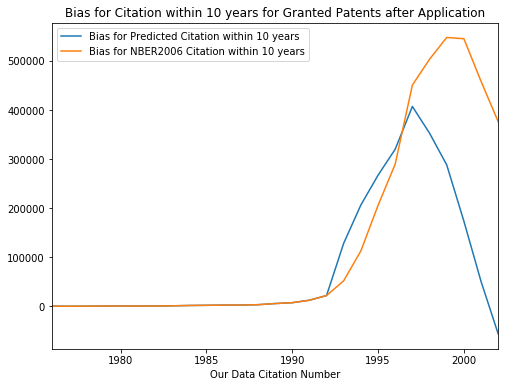

In [54]:
comp_plots_agg[["filed_year","bias_pred","bias_NBER"]].plot(x="filed_year", figsize=[8,6])
plt.legend(["Bias for Predicted Citation within 10 years", "Bias for NBER2006 Citation within 10 years"]);
plt.xlabel("Our Data Citation Number")
plt.title("Bias for Citation within 10 years for Granted Patents after Application")
savefig('ts_Pred_Our_Compare_cites10(V1).png')
plt.show()